# Introduction

This is an example for how to run the combined model in forward and inverse mode. If you want to apply it to measured data, just replace r_rs and wavelengths.

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import lmfit
from bio_optics.helper import resampling
from bio_optics.models import model
from bio_optics.atmosphere import downwelling_irradiance
from bio_optics.surface import surface
from bio_optics.water import absorption, backscattering
from matplotlib import pyplot as plt

First, we need to define the wavelength settings for our sensor, just replace this with the actual wavelengths for your data.

In [2]:
wavelengths = np.arange(400,800)

Next, we resample all spectral libraries involved to the to sensor's band settings. Using pre-computed spectra saves a lot of time because the model will compute all these spectra in every run, if you don't provide them.

In [4]:
a_i_spec_res = resampling.resample_a_i_spec(wavelengths)
a_w_res = resampling.resample_a_w(wavelengths)
b_phy_norm_res = resampling.resample_b_phy_norm(wavelengths)
bb_w_res = resampling.resample_bb_w(wavelengths)
R_b_i_res = resampling.resample_R_b_i(wavelengths)
E0_res = resampling.resample_E0(wavelengths)
a_oz_res = resampling.resample_a_oz(wavelengths)
a_ox_res = resampling.resample_a_ox(wavelengths)
a_wv_res = resampling.resample_a_wv(wavelengths)
da_w_div_dT_res = resampling.resample_da_w_div_dT(wavelengths)
n2_res = resampling.resample_n(wavelengths)

Ed_d_res = downwelling_irradiance.Ed_d(wavelengths)
Ed_sa_res = downwelling_irradiance.Ed_sa(wavelengths)
Ed_sr_res = downwelling_irradiance.Ed_sr(wavelengths)
Ed_res = Ed_d_res + Ed_sa_res + Ed_sr_res

The lmfit.parameter.Parameters object is an important part of the codebase and the input for the forward() and invert() functions. It is basically a dictionary that holds the values for the different variables of the model. Here, we set up some values and value ranges (min, max) for different variables of the model. In forward() mode the defined values will be the exact inputs into the model, in invert() mode the defined values will be the starting values for the inversion and the vary flag defines if these paramters are to be fit within the value range defined by min and max or not.

In [5]:
params = lmfit.Parameters()
params.add('C_0', value=2, min=0, max=100, vary=True)
params.add('C_1', value=0, min=0, max=100, vary=False)
params.add('C_2', value=0, min=0, max=100, vary=False)
params.add('C_3', value=0, min=0, max=100, vary=False)
params.add('C_4', value=0, min=0, max=100, vary=False)
params.add('C_5', value=0, min=0, max=100, vary=False)
params.add('C_Y', value=0.2, min=0, max=4, vary=True)
params.add('C_X', value=5, min=0.0, max=100, vary=True)
params.add('C_Mie', value=0, min=0.0, max=100, vary=True)
params.add('f_0', value=0, min=0, max=1, vary=True)
params.add('f_1', value=1, min=0, max=1, vary=True)
params.add('f_2', value=0, min=0, max=1, vary=True)
params.add('f_3', value=0, min=0, max=1, vary=True)
params.add('f_4', value=0, min=0, max=1, vary=True)
params.add('f_5', min=0, max=1, expr='1 - (f_0 + f_1 + f_2 + f_3 + f_4)')
params.add('B_0', value=1/np.pi, vary=False)
params.add('B_1', value=1/np.pi, vary=False)
params.add('B_2', value=1/np.pi, vary=False)
params.add('B_3', value=1/np.pi, vary=False)
params.add('B_4', value=1/np.pi, vary=False)
params.add('B_5', value=1/np.pi, vary=False)
params.add('bb_phy_spec', value=0.0010, vary=False)
params.add('bb_Mie_spec', value=0.0042, vary=False)
params.add('bb_X_spec', value=0.0086, min=0, max=1, vary=False)
params.add('b_X_norm_factor', value=1, vary=False)
params.add('a_NAP_spec_lambda_0', value=0.041, min=0.01, max=0.12, vary=False) 
params.add('S', value=0.014, min=0.007, max=0.026, vary=True) 
params.add('K', value=0, min=0, vary=False)
params.add('S_NAP', value=0.011, vary=False)
params.add('n', value=-1, min=-1, max=0, vary=False)
params.add('lambda_0', value=440, vary=False)
params.add('lambda_S', value=500, vary=False)
params.add('theta_sun', value=np.radians(30), min=np.radians(0), max=np.radians(90), vary=False)
params.add('theta_view', value=np.radians(40), min=np.radians(0), max=np.radians(90), vary=False)
params.add('n1', value=1, vary=False)
params.add('n2', value=1.33, vary=False)
params.add('kappa_0', value=1.0546, vary=False)
params.add('fresh', value=False, vary=False)
params.add('zB', value=10, min=0, max=100, vary=True)
params.add('T_W', value=25, min=0, max=40, vary=False)
params.add('T_W_0', value=20, vary=False)
params.add('error_method', value=2, vary=False)
params.add('P', value=1013.25, vary=False) 
params.add('AM', value=1, vary=False) 
params.add('RH', value=60, vary=False) 
params.add('H_oz', value=0.38, vary=False)
params.add('WV', value=2.5, vary=False) 
params.add('alpha', value=1.317, vary=False) 
params.add('beta', value=0.2606, vary=False) 
params.add('g_dd', value=0.02, min=-1, max=10, vary=True) 
params.add('g_dsr', value=1/np.pi, min=0, max=10, vary=True) 
params.add('g_dsa', value=1/np.pi, min=0, max=10, vary=True) 
params.add('d_r', value=0, min=0, max=0.1, vary=True) 
params.add('f_dd', value=1, vary=False) 
params.add('f_ds', value=1, vary=False) 
# params.add('rho_L', value=0.02006, vary=False) # rho_L is an optional parameter, if it is provided through the params object it will be used. if not, it will be computed using the Frensel equation.
params.add('offset', value=0, min=-0.1, max=0.1, vary=False)
params.add('fit_surface', value=True, vary=False)

Now let's simulate an above-water radiance reflectance spectrum using the parameters object, we just created and add some random noise.

In [6]:
rrs = model.forward(parameters=params, wavelengths=wavelengths)

noise = np.random.rand(len(wavelengths)) / 500
rrs = rrs + noise

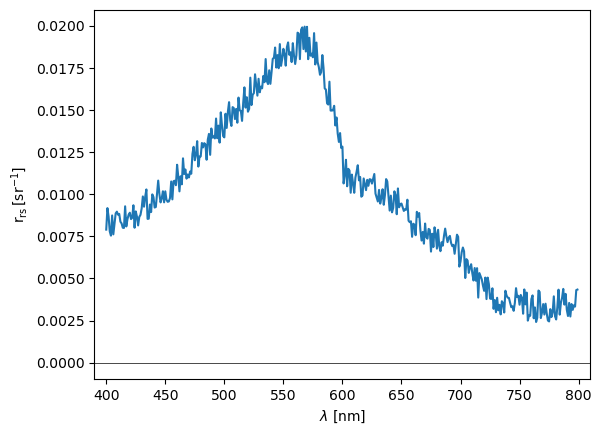

In [7]:
plt.plot(wavelengths, rrs)
plt.xlabel('$\lambda$ [nm]')
plt.ylabel('$\mathrm{r_{rs}} \/ [\mathrm{sr}^{-1}]$')
plt.hlines(0,300,1000, color='black', linewidth=0.5) #, linestyle='dotted')
plt.xlim(390,810)
plt.show()

Now, we pretend that the rrs spectrum, we just simulated is our measurement.
First, we define a weighting factor for each wavelength that defines how important it is when computing the residual between the simulated and measured spectrum. Let's go with a constant value of 1, i.e., all bands are equally important.

In [8]:
weights = np.ones(len(rrs))

Now we use the invert function of the model to find a good combination of model parameters that result in a spectrum that matches our measurement.
The most important inputs are the parameters object, the measured spectrum and the corresponding wavelengths. All other inputs are pre-computed to speed up the code,
but would be computed "on the fly" if not provided. Try to comment out all arguments between wavelengths and method to see how much longer the inversion takes without providing the pre-computed inputs.

In [10]:
result = model.invert(params = params, 
                      Rrs = rrs, 
                      wavelengths = wavelengths,
                      weights = weights,
                      a_i_spec_res = a_i_spec_res,
                      a_w_res = a_w_res,
                      b_phy_norm_res = b_phy_norm_res,
                      bb_w_res = bb_w_res,
                      R_b_i_res = R_b_i_res,
                      E0_res = E0_res,
                      a_oz_res = a_oz_res,
                      a_ox_res = a_ox_res,
                      a_wv_res = a_wv_res,
                      da_w_div_dT_res = da_w_div_dT_res,
                      Ed_d_res = Ed_d_res,
                      Ed_sa_res = Ed_sa_res,
                      Ed_sr_res = Ed_sr_res,
                      Ed_res = Ed_res,
                      method = "least_squares",
                      max_nfev = 400)

The output of the invert() function is a lmfit.minimizer.MinimizerResult object.

In [14]:
dir(result)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_calculate_statistics',
 '_init_vals_internal',
 '_repr_html_',
 'aborted',
 'aic',
 'bic',
 'call_kws',
 'chisqr',
 'covar',
 'errorbars',
 'flatchain',
 'init_vals',
 'init_values',
 'last_internal_values',
 'message',
 'method',
 'ndata',
 'nfev',
 'nfree',
 'nvarys',
 'params',
 'redchi',
 'residual',
 'show_candidates',
 'success',
 'var_names']

In [36]:
getattr(result, 'chisqr')

0.00012320415939232765

Now let's see how the inversion did. You can use the .params notation to access the variables, which are a stored in a parameters object and can be used as an input for the forward() function just as before. First we use the forward_glint() function to model R_rs_surf based on the inversion results.

In [23]:
Rrs_surf = model.forward_glint(result.params, wavelengths=wavelengths)

Now we can plot our measurement, the modeled spectrum, the estimated R_rs_surf and the estimated R_rs (measured - glint).

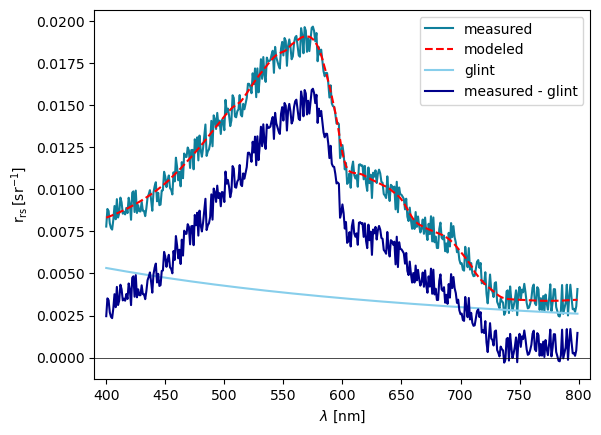

In [24]:
plt.plot(wavelengths, rrs, c='#0f7f9b', label="measured")
plt.plot(wavelengths, model.forward(result.params, wavelengths=wavelengths, Ed_res=Ed_res), '--', c='red', label='modeled')
plt.plot(wavelengths, Rrs_surf, c='skyblue', label="glint")
plt.plot(wavelengths, rrs - Rrs_surf, c='darkblue', label="measured - glint")
plt.xlabel('$\lambda$ [nm]')
plt.ylabel('$\mathrm{r_{rs}} \/ [\mathrm{sr}^{-1}]$')
plt.hlines(0,300,1000, color='black', linewidth=0.5)
plt.xlim(390,810)
plt.legend()
plt.show()

The forward() and invert() functions can also be used with measurements of absorption and backscattering. Let's simulate some example spectra.

In [25]:
measured_absorption = absorption.a(wavelengths=wavelengths, C_0=2, C_Y=0.5, C_X=3)
measured_backscattering = backscattering.bb(wavelengths=wavelengths, C_phy=2, C_X=3)

Note that the concentrations of optically active water parameters are set to 0 and the bottom type fraction of sand is set to 1, while all other bottom type fractions are 0. Here we ignore the surface and simulate $\mathrm{R_{rs}}$.

In [27]:
params = lmfit.Parameters()
params.add('C_0', value=0, min=0, max=100, vary=False)
params.add('C_1', value=0, min=0, max=100, vary=False)
params.add('C_2', value=0, min=0, max=100, vary=False)
params.add('C_3', value=0, min=0, max=100, vary=False)
params.add('C_4', value=0, min=0, max=100, vary=False)
params.add('C_5', value=0, min=0, max=100, vary=False)
params.add('C_Y', value=0, min=0, max=4, vary=False)
params.add('C_X', value=0, min=0.0, max=100, vary=False)
params.add('C_Mie', value=0, min=0.0, max=100, vary=False)
params.add('f_0', value=0, min=0, max=1, vary=False)
params.add('f_1', value=1, min=0, max=1, vary=False)
params.add('f_2', value=0, min=0, max=1, vary=False)
params.add('f_3', value=0, min=0, max=1, vary=False)
params.add('f_4', value=0, min=0, max=1, vary=False)
params.add('f_5', value=0, min=0, max=1, vary=False)
params.add('B_0', value=1/np.pi, vary=False)
params.add('B_1', value=1/np.pi, vary=False)
params.add('B_2', value=1/np.pi, vary=False)
params.add('B_3', value=1/np.pi, vary=False)
params.add('B_4', value=1/np.pi, vary=False)
params.add('B_5', value=1/np.pi, vary=False)
params.add('bb_phy_spec', value=0.0010, vary=False)
params.add('bb_Mie_spec', value=0.0042, vary=False)
params.add('bb_X_spec', value=0.0086, min=0, max=1, vary=False)
params.add('b_X_norm_factor', value=1, vary=False)
params.add('a_NAP_spec_lambda_0', value=0.041, min=0.01, max=0.12, vary=False) 
params.add('S', value=0.014, min=0.007, max=0.026, vary=True) 
params.add('K', value=0, min=0, vary=False)
params.add('S_NAP', value=0.011, vary=False)
params.add('n', value=-1, min=-1, max=0, vary=False)
params.add('lambda_0', value=440, vary=False)
params.add('lambda_S', value=500, vary=False)
params.add('theta_sun', value=np.radians(30), min=np.radians(0), max=np.radians(90), vary=False)
params.add('theta_view', value=np.radians(40), min=np.radians(0), max=np.radians(90), vary=False)
params.add('n1', value=1, vary=False)
params.add('n2', value=1.33, vary=False)
params.add('kappa_0', value=1.0546, vary=False)
params.add('fresh', value=False, vary=False)
params.add('zB', value=10, min=0, max=100, vary=False)
params.add('T_W', value=25, min=0, max=40, vary=False)
params.add('T_W_0', value=20, vary=False)
params.add('error_method', value=2, vary=False)
params.add('P', value=1013.25, vary=False) 
params.add('AM', value=1, vary=False) 
params.add('RH', value=60, vary=False) 
params.add('H_oz', value=0.38, vary=False)
params.add('WV', value=2.5, vary=False) 
params.add('alpha', value=1.317, vary=False) 
params.add('beta', value=0.2606, vary=False) 
params.add('g_dd', value=0.02, min=-1, max=10, vary=True) 
params.add('g_dsr', value=1/np.pi, min=0, max=10, vary=True) 
params.add('g_dsa', value=1/np.pi, min=0, max=10, vary=True) 
params.add('d_r', value=0, min=0, max=0.1, vary=True) 
params.add('f_dd', value=1, vary=False) 
params.add('f_ds', value=1, vary=False) 
# params.add('rho_L', value=0.02006, vary=False) # rho_L is an optional parameter, if it is provided through the params object it will be used. if not, it will be computed using the Frensel equation.
params.add('offset', value=0, min=-0.1, max=0.1, vary=False)
params.add('fit_surface', value=False, vary=False)

In [33]:
Rrs = model.forward(parameters=params,
                    wavelengths=wavelengths,
                    a_res=measured_absorption,
                    bb_res=measured_backscattering)

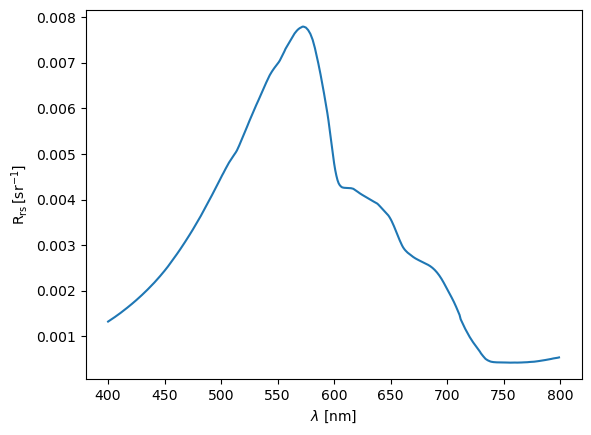

In [34]:
plt.plot(wavelengths, Rrs)
plt.xlabel('$\lambda$ [nm]')
plt.ylabel('$\mathrm{R_{rs}} \/ [\mathrm{sr}^{-1}]$')
plt.show()

Now let's pretend have a measured $\mathrm{R_{rs}}$ spectrum as well as absorption and backscattering and want to know benthic reflectance. We can use the inversion() function to find out. We pretend that we know depth but don't know that the bottom type is sand and set f_1 to 0.

In [35]:
params.add('f_1', value=0, min=0, max=1, vary=True)

In [40]:
result = model.invert(params = params, 
                      Rrs = Rrs, 
                      wavelengths = wavelengths,
                      a_res= measured_absorption,
                      bb_res= measured_backscattering,
                      weights = weights,
                      a_i_spec_res = a_i_spec_res,
                      a_w_res = a_w_res,
                      b_phy_norm_res = b_phy_norm_res,
                      bb_w_res = bb_w_res,
                      R_i_b_res = R_i_b_res,
                      E0_res = E0_res,
                      a_oz_res = a_oz_res,
                      a_ox_res = a_ox_res,
                      a_wv_res = a_wv_res,
                      da_w_div_dT_res = da_w_div_dT_res,
                      Ed_d_res = Ed_d_res,
                      Ed_sa_res = Ed_sa_res,
                      Ed_sr_res = Ed_sr_res,
                      Ed_res = Ed_res,
                      method = "least_squares",
                      max_nfev = 400)

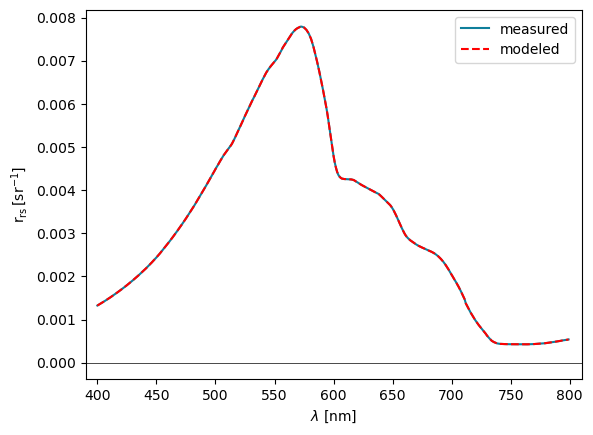

In [43]:
plt.plot(wavelengths, Rrs, c='#0f7f9b', label="measured")
plt.plot(wavelengths, model.forward(result.params, 
                                    wavelengths=wavelengths, 
                                    a_res=measured_absorption, 
                                    bb_res=measured_backscattering), '--', c='red', label='modeled')
plt.xlabel('$\lambda$ [nm]')
plt.ylabel('$\mathrm{r_{rs}} \/ [\mathrm{sr}^{-1}]$')
plt.hlines(0,300,1000, color='black', linewidth=0.5)
plt.xlim(390,810)
plt.legend()
plt.show()

In [44]:
result